In [2]:
library(tidyverse)
library(readr)
library(dplyr)
library(stringr)
library(tidymodels)
library(yardstick)
library(ggplot2)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod"
file_path <- "cleve.mod"
download.file(url, destfile = file_path)
heart_data <- read_table(file_path, skip = 20, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                                                    "thalach", "exang", "oldpeak", "slope", "ca", "thal", 
                                                                    "disease"), na = "?")

heart_data$disease <- str_replace_all(string = heart_data$disease, pattern = "buff", replacement = "healthy")
head(heart_data)


── Column specification ────────────────────────────────────────────────────────
cols(
  age = col_double(),
  sex = col_character(),
  cp = col_character(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_character(),
  restecg = col_character(),
  thalach = col_double(),
  exang = col_character(),
  oldpeak = col_double(),
  slope = col_character(),
  ca = col_double(),
  thal = col_character(),
  disease = col_character()
)

Warning message:
“303 parsing failures.
row col   expected     actual        file
  1  -- 14 columns 15 columns 'cleve.mod'
  2  -- 14 columns 15 columns 'cleve.mod'
  3  -- 14 columns 15 columns 'cleve.mod'
  4  -- 14 columns 15 columns 'cleve.mod'
  5  -- 14 columns 15 columns 'cleve.mod'
... ... .......... .......... ...........
See problems(...) for more details.
”


age sex  cp     trestbps chol fbs  restecg thalach exang oldpeak slope ca
1 63  male angina 145      233  true hyp     150     fal   2.3     down  0 
2 67  male asympt 160      286  fal  hyp     108     true  1.5     flat  3 
3 67  male asympt 120      229  fal  hyp     129     true  2.6     flat  2 
4 37  male notang 130      250  fal  norm    187     fal   3.5     down  0 
5 41  fem  abnang 130      204  fal  hyp     172     fal   1.4     up    0 
6 56  male abnang 120      236  fal  norm    178     fal   0.8     up    0 
  thal disease
1 fix  healthy
2 norm sick   
3 rev  sick   
4 norm healthy
5 norm healthy
6 norm healthy

In [4]:
set.seed(8888)
# split data into training and testing data
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [5]:
heart_recipe <- recipe(disease ~ thalach + oldpeak, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease)
heart_k <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_tune) |>
  tune_grid(resamples = heart_vfold, gird = 10) |>
  collect_metrics() |>
  filter(.metric == "accuracy") 
head(heart_k)

Warning message:
“The `...` are not used in this function but one or more objects were passed: 'gird'”


neighbors .metric  .estimator mean      n std_err    .config             
1  2        accuracy binary     0.6515810 5 0.03214669 Preprocessor1_Model1
2  4        accuracy binary     0.6632411 5 0.02048674 Preprocessor1_Model2
3  5        accuracy binary     0.6940711 5 0.02675951 Preprocessor1_Model3
4  7        accuracy binary     0.6851779 5 0.02759307 Preprocessor1_Model4
5  9        accuracy binary     0.7120553 5 0.03435781 Preprocessor1_Model5
6 10        accuracy binary     0.7166008 5 0.03126405 Preprocessor1_Model6

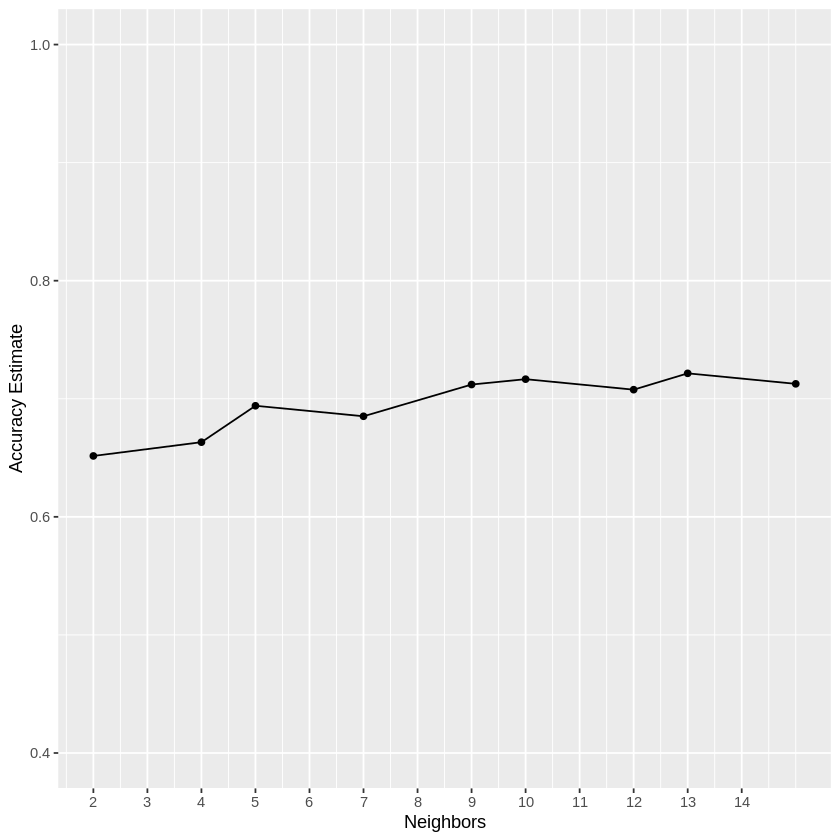

In [6]:
accuracies <- heart_k |> 
      filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [7]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_spec) |>
  fit(data = heart_train)
# predict
heart_predict <- predict(heart_fit, heart_test) |>
  bind_cols(heart_test)
heart_predict

.pred_class age sex  cp     trestbps chol fbs  restecg thalach exang oldpeak
1  sick        67  male asympt 160      286  fal  hyp     108     true  1.5    
2  healthy     41  fem  abnang 130      204  fal  hyp     172     fal   1.4    
3  healthy     57  fem  asympt 120      354  fal  norm    163     true  0.6    
4  sick        64  male angina 110      211  fal  hyp     144     true  1.8    
5  healthy     58  male abnang 120      284  fal  hyp     160     fal   1.8    
6  healthy     43  male asympt 150      247  fal  norm    171     fal   1.5    
7  healthy     60  male asympt 117      230  true norm    160     true  1.4    
8  sick        65  fem  asympt 150      225  fal  hyp     114     fal   1.0    
9  healthy     58  male notang 112      230  fal  hyp     165     fal   2.5    
10 healthy     53  male notang 130      197  true hyp     152     fal   1.2    
11 healthy     65  male asympt 120      177  fal  norm    140     fal   0.4    
12 healthy     60  male asympt 130      253  fal  norm    144     true  1.4    
13 healthy     50  male notang 140      233  fal  norm    163     fal   0.6    
14 sick        54  male asympt 120      188  fal  norm    113     fal   1.4    
15 sick        60  male notang 140      185  fal  hyp     155     fal   3.0    
16 healthy     54  male notang 150      232  fal  hyp     165     fal   1.6    
17 sick        62  male asympt 120      267  fal  norm     99     true  1.8    
18 healthy     48  male abnang 130      245  fal  hyp     180     fal   0.2    
19 sick        58  male asympt 150      270  fal  hyp     111     true  0.8    
20 sick        45  male asympt 104      208  fal  hyp     148     true  3.0    
21 healthy     68  male notang 180      274  true hyp     150     true  1.6    
22 healthy     44  male notang 140      235  fal  hyp     180     fal   0.0    
23 healthy     47  male notang 138      257  fal  hyp     156     fal   0.0    
24 healthy     53  fem  asympt 138      234  fal  hyp     160     fal   0.0    
25 sick        62  fem  asympt 160      164  fal  hyp     145     fal   6.2    
26 sick        60  fem  asympt 150      258  fal  hyp     157     fal   2.6    
27 healthy     52  male abnang 134      201  fal  norm    158     fal   0.8    
28 sick        56  male asympt 125      249  true hyp     144     true  1.2    
29 healthy     52  male angina 118      186  fal  hyp     190     fal   0.0    
30 healthy     58  male notang 140      211  true hyp     165     fal   0.0    
⋮  ⋮           ⋮   ⋮    ⋮      ⋮        ⋮    ⋮    ⋮       ⋮       ⋮     ⋮      
48 healthy     50  male asympt 144      200  fal  hyp     126     true  0.9    
49 healthy     55  male abnang 130      262  fal  norm    155     fal   0.0    
50 sick        64  fem  asympt 130      303  fal  norm    122     fal   2.0    
51 healthy     41  fem  notang 112      268  fal  hyp     172     true  0.0    
52 healthy     39  fem  notang  94      199  fal  norm    179     fal   0.0    
53 sick        53  male asympt 123      282  fal  norm     95     true  2.0    
54 healthy     47  male asympt 112      204  fal  norm    143     fal   0.1    
55 healthy     52  fem  notang 136      196  fal  hyp     169     fal   0.1    
56 sick        55  fem  asympt 180      327  fal  abn     117     true  3.4    
57 healthy     41  fem  abnang 126      306  fal  norm    163     fal   0.0    
58 healthy     43  male asympt 115      303  fal  norm    181     fal   1.2    
59 healthy     67  fem  asympt 106      223  fal  norm    142     fal   0.3    
60 sick        76  fem  notang 140      197  fal  abn     116     fal   1.1    
61 sick        71  fem  asympt 112      149  fal  norm    125     fal   1.6    
62 sick        57  male asympt 110      335  fal  norm    143     true  3.0    
63 sick        55  fem  asympt 128      205  fal  abn     130     true  2.0    
64 healthy     61  male asympt 148      203  fal  norm    161     fal   0.0    
65 healthy     58  male abnang 125      220  fal  norm    144     fal   0.4    
66 

In [8]:
accuracies <- knn_results |> 
      filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

ERROR: Error in eval(expr, envir, enclos): object 'knn_results' not found


In [ ]:
heart_predict <- mutate(heart_predict, disease = as.factor(disease))
heart_accuracy <- heart_predict |>
  metrics(truth = disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")
heart_accuracy
heart_mat <- heart_predict |>
  conf_mat(truth = disease, estimate = .pred_class)
heart_mat

In [9]:
# Create the grid of thalach/oldpeak values, and arrange in a data frame
thalach_grid <- seq(min(heart_data$thalach, na.rm = TRUE),
                    max(heart_data$thalach, na.rm = TRUE),
                    length.out = 100)
oldpeak_grid <- seq(min(heart_data$oldpeak, na.rm = TRUE),
                    max(heart_data$oldpeak, na.rm = TRUE),
                    length.out = 100)


thalach_oldpeak_grid <- as_tibble(expand.grid(thalach = thalach_grid,
                                              oldpeak = oldpeak_grid))

# Use the fit workflow to make predictions at the grid points
knn_pred_grid <- predict(heart_fit, thalach_oldpeak_grid)

# Bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knn_pred_grid, thalach_oldpeak_grid) |>
  rename(disease = .pred_class) 
prediction_table

disease thalach   oldpeak
1     sick     71.00000 0      
2     sick     72.32323 0      
3     sick     73.64646 0      
4     sick     74.96970 0      
5     sick     76.29293 0      
6     sick     77.61616 0      
7     sick     78.93939 0      
8     sick     80.26263 0      
9     sick     81.58586 0      
10    sick     82.90909 0      
11    sick     84.23232 0      
12    sick     85.55556 0      
13    sick     86.87879 0      
14    sick     88.20202 0      
15    sick     89.52525 0      
16    sick     90.84848 0      
17    sick     92.17172 0      
18    sick     93.49495 0      
19    sick     94.81818 0      
20    sick     96.14141 0      
21    sick     97.46465 0      
22    sick     98.78788 0      
23    sick    100.11111 0      
24    sick    101.43434 0      
25    sick    102.75758 0      
26    sick    104.08081 0      
27    sick    105.40404 0      
28    healthy 106.72727 0      
29    healthy 108.05051 0      
30    healthy 109.37374 0      
⋮     ⋮       ⋮         ⋮      
9971  sick    163.6263  6.2    
9972  sick    164.9495  6.2    
9973  sick    166.2727  6.2    
9974  sick    167.5960  6.2    
9975  sick    168.9192  6.2    
9976  sick    170.2424  6.2    
9977  sick    171.5657  6.2    
9978  sick    172.8889  6.2    
9979  sick    174.2121  6.2    
9980  sick    175.5354  6.2    
9981  sick    176.8586  6.2    
9982  sick    178.1818  6.2    
9983  sick    179.5051  6.2    
9984  sick    180.8283  6.2    
9985  sick    182.1515  6.2    
9986  sick    183.4747  6.2    
9987  sick    184.7980  6.2    
9988  sick    186.1212  6.2    
9989  sick    187.4444  6.2    
9990  sick    188.7677  6.2    
9991  sick    190.0909  6.2    
9992  sick    191.4141  6.2    
9993  sick    192.7374  6.2    
9994  sick    194.0606  6.2    
9995  sick    195.3838  6.2    
9996  sick    196.7071  6.2    
9997  sick    198.0303  6.2    
9998  sick    199.3535  6.2    
9999  sick    200.6768  6.2    
10000 sick    202.0000  6.2

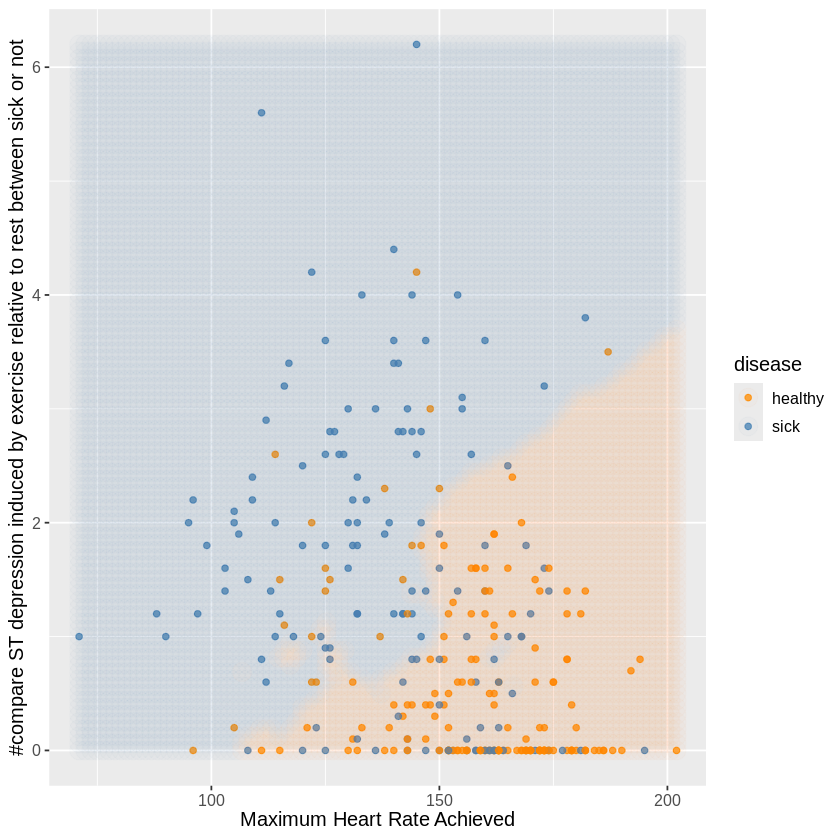

In [10]:
#plot
heart_plot <-
  ggplot() +
  geom_point(data = heart_data,
             mapping = aes(x = thalach,
                           y = oldpeak,
                           color = disease),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = thalach,
                           y = oldpeak,
                           color = disease),
             alpha = 0.02,
             size = 5) +
  labs(color = "disease",
       x = "Maximum Heart Rate Achieved",
       y = "#compare ST depression induced by exercise relative to rest between sick or not") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot
# Scatter plot of thalach versus oldpeak where background color indicates the decision of the classifier.